In [1]:
# Load libraries
%reload_ext lab_black
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt

# -------------- model selection ---------------#
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# --------------- model metrics ----------------#
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

# ---------------- build models ----------------#
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_csv("data/Iris.csv")
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 1. Exploratory Data Analysis

In [3]:
df.shape

(150, 5)

In [4]:
# check the df for all required stats
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
# class distribution
print(df.groupby("Species").size())

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


## 2. Data Visualization

### 2.1 Univariate Plots

We start with some univariate plots, that is, plots of each individual variable.

Given that the input variables are numeric, we can create box and whisker plots of each.

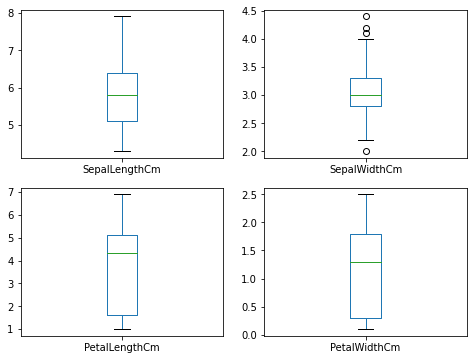

In [6]:
# box and whisker plots
df.plot(
    kind="box", subplots=True, layout=(2, 2), figsize=(8, 6), sharex=False, sharey=False
)
plt.show()

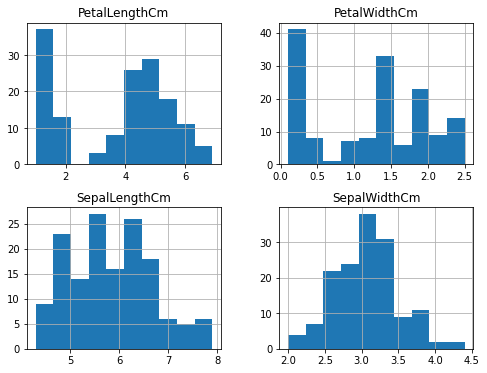

In [7]:
# histogram of each input variable to get an idea of the distribution
df.hist(figsize=(8, 6))
plt.show()

It looks like perhaps two of the input variables have a Gaussian distribution. This is useful to note as we can use algorithms that can exploit this assumption.

## 2.2 Multivariate Plots
Scatterplots of all pairs of attributes. This can be helpful to spot structured relationships between input variables.

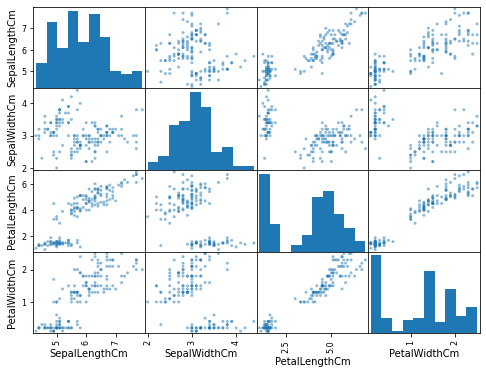

In [8]:
# scatter plot matrix
scatter_matrix(df, figsize=(8, 6))
plt.show()

The diagonal grouping of some pairs of attributes suggests a high correlation and a predictable relationship.

## 3. Create a test-train validation Dataset

In [9]:
# Split-out test (validation) dataset
array = df.values
X = array[:, 0:4]
y = array[:, 4]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.20, random_state=1
)

We will use stratified 10-fold cross validation to estimate model accuracy.

This will split our dataset into 10 parts, train on 9 and test on 1 and repeat for all combinations of train-test splits.

Stratified means that each fold or split of the dataset will aim to have the same distribution of example by class as exist in the whole training dataset.

## 4. Build Models
### 4.1 Model Selection

In [10]:
# Spot Check Algorithms
models = []
models.append(("LR", LogisticRegression(solver="liblinear", multi_class="ovr"),))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC(gamma="auto")))
models.append(("GB", GradientBoostingClassifier(random_state=0)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.941667 (0.065085)
LDA: 0.975000 (0.038188)
KNN: 0.958333 (0.041667)
CART: 0.958333 (0.041667)
NB: 0.950000 (0.055277)
SVM: 0.983333 (0.033333)
GB: 0.958333 (0.041667)


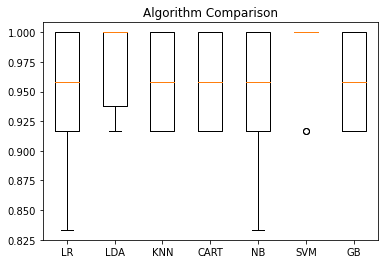

In [11]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title("Algorithm Comparison")
plt.show()

We can see that it looks like Support Vector Machines (SVM) has the largest estimated accuracy score at about 0.98 or 98%.

## 4.2 Predictions
### SVM:

In [12]:
# Make predictions on validation dataset
model = SVC(gamma="auto")
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [13]:
# Evaluate predictions
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



We can see that the accuracy is 0.966 or about 96% on the hold out dataset.

In [14]:
# scores
# mse = mean_squared_error(Y_test, predictions)
# rmse = np.sqrt(mse)
# r2 = r2_score(Y_test, predictions)
# print("MSE for LR:", mse)
# print("RMSE for LR:", rmse)
# print("R2_Score for LR:", r2)

## KNN

In [19]:
classifier = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
acc

1.0

In [20]:
print(accuracy_score(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

1.0
[[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00         6

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



In [ ]:
KNN performs even better than SVM here